Enter dataset path (CSV/XLSX):  soldiers2023.csv



=== Column names & dtypes ===
[0]                 time  dtype=object
[1]              Wykleci  dtype=int64
[2]                   AK  dtype=int64
[3]                  NSZ  dtype=int64

=== First rows ===


,time,Wykleci,AK,NSZ
0,2004-01,6,4,4
1,2004-02,10,8,0
2,2004-03,4,12,0
3,2004-04,0,13,0
4,2004-05,0,9,3



[hint] Best date-like column guess: 'time' (coverage ~100%)
[hint] Numeric y candidates: ['Wykleci', 'AK', 'NSZ']



Enter the DATE column name (as printed above), or leave blank for auto-detect / Year+Month:  time
Enter the TARGET (y) column name (as printed above), or numeric index:  Wykleci
Monthly aggregation ('mean' or 'sum') [default: mean]:  mean



Loaded & normalized → index=DatetimeIndex | rows=239 | columns=['Wykleci', 'AK', 'NSZ'] | y='Wykleci'
Date range: 2004-01-01 → 2023-11-01 (monthly MS)


Enter intervention date (YYYY-MM or YYYY-MM-DD). Blank = auto-detect:  2011-03


PRE : (Timestamp('2004-01-01 00:00:00'), Timestamp('2011-02-01 00:00:00'))
POST: (Timestamp('2011-03-01 00:00:00'), Timestamp('2023-11-01 00:00:00'))


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

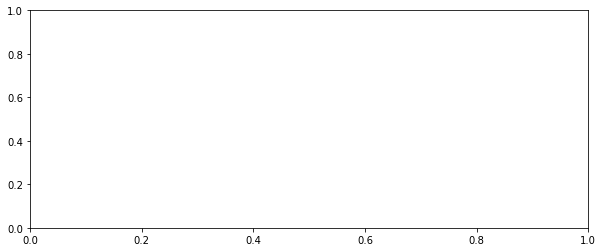

In [1]:
#!/usr/bin/env python3
"""
Guided CausalImpact runner with robust patches + SARIMAX fallback.

- Loads CSV/XLSX or DataFrame from path
- Normalizes to monthly MS, cleans series
- Tries python causalimpact with staged fixes & diagnostics (if installed)
- If causalimpact returns inferences=None, falls back to SARIMAX deterministic counterfactual
- Plots results and prints summaries
"""
import os
import re
import warnings
from typing import Optional, Tuple, Union, List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)
os.environ.setdefault("NUMBA_DISABLE_JIT", "1")

# Optional CausalImpact
_CI_OK = True
try:
    from causalimpact import CausalImpact
except Exception as _ci_err:
    _CI_OK = False
    print("[info] CausalImpact unavailable:", _ci_err)

# ------------------ helpers: dates & loading ------------------
def _coerce_monthlike_to_ts(s: pd.Series) -> pd.Series:
    """Coerce YYYY-MM / YYYY/MM / YYYYMM / 200401 → Timestamp (month start)."""
    if pd.api.types.is_numeric_dtype(s):
        s = s.astype("Int64").astype(str)
    s = s.astype(str).str.strip()
    s = s.str.replace(r"[./]", "-", regex=True)
    s = s.str.replace(r"^(\d{4})(\d{2})$", r"\1-\2", regex=True)
    return pd.to_datetime(s, format="%Y-%m", errors="coerce")

def _guess_date_col(df: pd.DataFrame):
    """Pick a date-like column with best conversion coverage."""
    best, rate = None, 0.0
    for c in df.columns:
        try:
            ts = pd.to_datetime(df[c], errors="coerce")
            r = ts.notna().mean()
            if r > rate: best, rate = (c, ts), r
        except Exception:
            pass
        try:
            ts = _coerce_monthlike_to_ts(df[c])
            r = ts.notna().mean()
            if r > rate: best, rate = (c, ts), r
        except Exception:
            pass
    return (best[0], rate) if best else (None, 0.0)

def _maybe_from_year_month(df: pd.DataFrame):
    """Build dates from Year/Month columns (handles EN/PL variants)."""
    yc = [c for c in df.columns if re.fullmatch(r"(?i)year|rok|yyyy", str(c))]
    mc = [c for c in df.columns if re.fullmatch(r"(?i)month|miesi[aą]c|mm", str(c))]
    if yc and mc:
        y = pd.to_numeric(df[yc[0]], errors="coerce").astype("Int64")
        m = pd.to_numeric(df[mc[0]], errors="coerce").astype("Int64")
        return pd.to_datetime(y.astype(str) + "-" + m.astype(str), format="%Y-%m", errors="coerce")
    return None

def _force_monthly(df: pd.DataFrame, idx: Optional[Union[pd.Index, pd.Series]], agg="mean") -> pd.DataFrame:
    """Normalize to monthly (MS). If no dates → numeric index."""
    out = df.copy()
    if idx is None:
        return out.reset_index(drop=True)
    if isinstance(idx, pd.PeriodIndex):
        idx = idx.to_timestamp("MS")
    idx = pd.to_datetime(idx, errors="coerce")
    out = out.loc[idx.notna()].copy()
    out.index = idx[idx.notna()]
    out = out.sort_index()
    if isinstance(out.index, pd.DatetimeIndex):
        if out.index.inferred_freq not in ("MS", "M"):
            out = (out.resample("MS").sum(min_count=1) if agg == "sum" else out.resample("MS").mean())
        else:
            out = out.asfreq("MS")
    return out

def load_any_series(path_or_df: Union[str, pd.DataFrame], y_col=None, date_col=None,
                    monthly_agg="mean", fill_y=True) -> Tuple[pd.DataFrame, str]:
    """Load CSV/XLSX/DataFrame → monthly DF (y first) cleaned & ready."""
    if isinstance(path_or_df, (str, bytes)):
        p = str(path_or_df)
        raw = pd.read_excel(p) if p.lower().endswith((".xlsx", ".xls")) else pd.read_csv(p)
    else:
        raw = path_or_df.copy()

    if isinstance(raw.index, pd.PeriodIndex):
        raw.index = raw.index.to_timestamp("MS")

    # choose index
    if date_col and date_col in raw.columns:
        idx = pd.to_datetime(raw.pop(date_col), errors="coerce")
    else:
        ts = _maybe_from_year_month(raw)
        if ts is None:
            guessed, _ = _guess_date_col(raw)
            if guessed:
                idx = pd.to_datetime(raw.pop(guessed), errors="coerce")
            else:
                idx = None
        else:
            idx = ts

    # numeric conversion
    num = raw.copy()
    for c in num.columns:
        num[c] = pd.to_numeric(num[c], errors="coerce")

    # pick y
    if y_col is None:
        num_cols = [c for c in num.columns if pd.api.types.is_numeric_dtype(num[c])]
        if not num_cols:
            raise ValueError("No numeric columns found for y.")
        y_col = num_cols[0]
    yname = num.columns[y_col] if isinstance(y_col, int) else y_col
    cols = [yname] + [c for c in num.columns if c != yname]
    num = num[cols].copy()

    # monthly + cleaning
    data = _force_monthly(num, idx, agg=monthly_agg)

    # Interpolate/Fill: stronger fill strategy to avoid NAs inside pre/post
    if fill_y:
        data.iloc[:, 0] = data.iloc[:, 0].interpolate(limit_direction="both").ffill().bfill()
    data = data.dropna(subset=[data.columns[0]])
    for c in data.columns[1:]:
        if data[c].isna().any():
            data[c] = data[c].interpolate(limit_direction="both").ffill().bfill()

    # drop near-constant covariates
    drop_const = [c for c in data.columns[1:] if data[c].std(skipna=True) < 1e-12 or data[c].nunique(dropna=True) < 2]
    if drop_const:
        print(f"[info] Dropping near-constant covariates: {drop_const}")
        data = data.drop(columns=drop_const)

    # ensure numeric dtype
    for c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce").astype(float)

    return data, yname

def preview_file(path: str, n=5):
    """Print columns, dtypes, head; give hints for date/y selection."""
    raw = pd.read_excel(path) if path.lower().endswith((".xlsx", ".xls")) else pd.read_csv(path)
    print("\n=== Column names & dtypes ===")
    d = raw.dtypes.astype(str)
    for i, c in enumerate(raw.columns):
        print(f"[{i}] {c:>20s}  dtype={d[c]}")
    print("\n=== First rows ===")
    try:
        display(raw.head(n))
    except Exception:
        print(raw.head(n))
    # hints
    guess, rate = _guess_date_col(raw)
    ym = _maybe_from_year_month(raw)
    if guess:
        print(f"\n[hint] Best date-like column guess: '{guess}' (coverage ~{rate:.0%})")
    if ym is not None:
        print("[hint] Detected Year/Month columns that can build dates.")
    nums = [c for c in raw.columns if pd.api.types.is_numeric_dtype(raw[c])]
    if nums:
        print("[hint] Numeric y candidates:", nums)

# ------------------ CI patches: staged fixes ------------------
def _ci_try(df: pd.DataFrame, pre: tuple, post: tuple, label: str, extra_model_args: dict = None):
    """Try CausalImpact and return (ok, impact or None, message)."""
    # convert to list form that CausalImpact expects
    pre_list = [pre[0], pre[1]]
    post_list = [post[0], post[1]]
    # diagnostics
    print(f"[ci_try] Attempt '{label}': data shape={df.shape}")
    print(f"[ci_try] dtypes:\n{df.dtypes}")
    if isinstance(df.index, pd.DatetimeIndex):
        print(f"[ci_try] index freq inferred: {df.index.inferred_freq}  first/last: {df.index.min()} / {df.index.max()}")
    # ensure no NA
    if df.isna().any().any():
        print("[ci_try] Warning: input contains NAs; filling with linear interp + bfill/ffill.")
        df = df.interpolate(limit_direction="both").ffill().bfill()
    # require float dtype
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)
    # ensure pre/post endpoints exist in index for datetime
    if isinstance(df.index, pd.DatetimeIndex):
        if pre_list[0] not in df.index or pre_list[1] not in df.index or post_list[0] not in df.index or post_list[1] not in df.index:
            print("[ci_try] Nudging pre/post to closest available index values.")
            def _closest(ts):
                if ts in df.index: return ts
                # choose nearest by position
                pos = np.searchsorted(df.index, ts)
                pos = min(max(pos, 0), len(df.index)-1)
                return df.index[pos]
            pre_list = [_closest(pre_list[0]), _closest(pre_list[1])]
            post_list = [_closest(post_list[0]), _closest(post_list[1])]
            print(f"[ci_try] Using pre={pre_list}, post={post_list}")
    # default model args
    model_args = {"niter": 2000, "standardize": True}
    if extra_model_args:
        model_args.update(extra_model_args)
    try:
        impact = CausalImpact(df, pre_list, post_list, model_args=model_args)
        if getattr(impact, "inferences", None) is not None:
            print(f"[OK] CausalImpact succeeded: {label}")
            return True, impact, ""
        # Some CausalImpact runs construct object but inferences missing -> diagnostic
        info = f"[warn] CausalImpact returned inferences=None ({label}). Try: check pre/post lengths, model_args, or underlying sampler."
        return False, None, info
    except Exception as e:
        return False, None, f"[warn] CausalImpact failed ({label}): {e}"

def _filter_by_corr_pre(df: pd.DataFrame, pre: tuple, thr=0.2) -> pd.DataFrame:
    """Keep covariates correlated with y (|r|>=thr) in pre-period."""
    ycol = df.columns[0]
    if isinstance(df.index, pd.DatetimeIndex):
        pre_df = df.loc[pre[0]:pre[1]]
    else:
        pre_df = df.iloc[pre[0]:pre[1]+1]
    cors = pre_df.corr(numeric_only=True)[ycol].drop(index=ycol).sort_values(ascending=False)
    keep = cors[cors.abs() >= thr].index.tolist()
    print(f"[patch] Keeping covariates by pre-corr (|r|≥{thr}):", keep)
    return df[[ycol] + keep].copy()

def _drop_collinear_pre(df: pd.DataFrame, pre: tuple, cutoff=0.98) -> pd.DataFrame:
    """Drop covariates with pairwise |r|>cutoff in pre-period."""
    if df.shape[1] <= 2:
        return df
    X = df.iloc[:, 1:].copy()
    if isinstance(df.index, pd.DatetimeIndex):
        preX = X.loc[pre[0]:pre[1]]
    else:
        preX = X.iloc[pre[0]:pre[1]+1]
    C = preX.corr().abs()
    upper = C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > cutoff)]
    if to_drop:
        print(f"[patch] Dropping collinear covariates (|r|>{cutoff}):", to_drop)
        X = X.drop(columns=to_drop, errors="ignore")
    return pd.concat([df.iloc[:, [0]], X], axis=1)

def _enforce_consecutive_months(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure monthly MS frequency; interpolate covariates if needed."""
    if not isinstance(df.index, pd.DatetimeIndex):
        return df
    out = df.asfreq("MS")
    for c in out.columns[1:]:
        if out[c].isna().any():
            out[c] = out[c].interpolate(limit_direction="both").ffill().bfill()
    # also ensure target filled
    if out.iloc[:,0].isna().any():
        out.iloc[:,0] = out.iloc[:,0].interpolate(limit_direction="both").ffill().bfill()
    return out

def _nudge_split_if_needed(df: pd.DataFrame, pre: tuple, post: tuple) -> Tuple[tuple, tuple]:
    """If split lands on a gap, nudge post start to nearest available and adjust pre end."""
    if not isinstance(df.index, pd.DatetimeIndex):
        return pre, post
    # find actual nearest available for post[0]
    if post[0] not in df.index:
        # nearest index >= original
        idx = df.index[df.index >= post[0]]
        if len(idx) == 0:
            idx = df.index  # fallback to last
        new_post_start = idx[0]
        new_pre_end = df.index[df.index.get_loc(new_post_start) - 1] if new_post_start != df.index[0] else new_post_start
        pre = (pre[0], new_pre_end)
        post = (new_post_start, post[1])
        print(f"[patch] Nudged split → POST starts at {new_post_start.date()}, PRE ends at {new_pre_end.date()}")
    return pre, post

# ------------------ periods & fallback DID/OLS / SARIMAX ------------------
def detect_intervention(df: pd.DataFrame, method="cusum", min_pre=30, min_post=10):
    y = df.iloc[:,0].astype(float).values
    n = len(df)
    if n < (min_pre+min_post+1):
        cut = max(min_pre, int(round(0.7*n))); cut = min(cut, n-min_post)
        return df.index[cut] if isinstance(df.index, pd.DatetimeIndex) else cut
    if method == "maxdiff":
        diffs = np.abs(np.diff(y))
        k = int(np.nanargmax(diffs)) + 1 if np.isfinite(diffs).any() else int(round(0.7*n))
        cut = k
    else:
        yy = (y - np.nanmean(y)) / (np.nanstd(y) + 1e-12)
        cs = np.nancumsum(yy)
        t = np.arange(1, n+1)
        m, b = np.linalg.lstsq(np.vstack([t, np.ones(n)]).T, cs, rcond=None)[0]
        csd = cs - (m*t + b)
        k = int(np.nanargmax(np.abs(csd)))
        cut = max(1, min(n-1, k+1))
    cut = max(min_pre, min(n-min_post, cut))
    return df.index[cut] if isinstance(df.index, pd.DatetimeIndex) else cut

def make_periods_safe(df: pd.DataFrame, intervention=None, mode="date", ratio=0.7):
    if isinstance(df.index, pd.DatetimeIndex):
        if mode == "date" and intervention is not None:
            t0 = pd.to_datetime(intervention)
            pre_idx  = df.index[df.index < t0]
            post_idx = df.index[df.index >= t0]
            if len(pre_idx)>0 and len(post_idx)>0:
                pre  = (df.index.min(), pre_idx.max())
                post = (post_idx.min(), df.index.max())
                return pre, post
        k = max(30, int(round(len(df)*ratio))); k = min(k, len(df)-10)
        return (df.index[0], df.index[k-1]), (df.index[k], df.index[-1])
    else:
        n = len(df)
        if isinstance(intervention, int):
            k = min(max(30, intervention), n-10)
        else:
            k = max(30, int(round(n*ratio))); k = min(k, n-10)
        return (0, k-1), (k, n-1)

def run_did_ols(df: pd.DataFrame, pre: tuple, post: tuple):
    import statsmodels.api as sm
    if isinstance(pre[0], pd.Timestamp):
        is_post = (df.index >= post[0]).astype(int)
    else:
        is_post = (np.arange(len(df)) >= post[0]).astype(int)
    y = df.iloc[:,0]
    X = pd.concat([pd.Series(is_post, index=df.index, name="post"), df.iloc[:,1:]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags":3})
    print(res.summary().tables[1])
    return res

def run_sarimax_counterfactual(df: pd.DataFrame, pre: tuple, post: tuple,
                               order=(1,0,1), seasonal_order=(0,0,0,0), alpha=0.05):
    """
    Fit SARIMAX on pre-period (with exog covariates if available), forecast post, and compute effects.
    Returns dict with forecast_mean, forecast_ci, effect, cumulative effect, and model result.
    """
    import statsmodels.api as sm

    y = df.iloc[:, 0]
    exog = df.iloc[:, 1:] if df.shape[1] > 1 else None

    # Select slices (handles datetime and integer indices)
    if isinstance(df.index, pd.DatetimeIndex):
        y_pre = y.loc[pre[0]:pre[1]]
        y_post = y.loc[post[0]:post[1]]
        exog_pre = exog.loc[pre[0]:pre[1]] if exog is not None else None
        exog_post = exog.loc[post[0]:post[1]] if exog is not None else None
    else:
        y_pre = y.iloc[pre[0]:pre[1]+1]
        y_post = y.iloc[post[0]:post[1]+1]
        exog_pre = exog.iloc[pre[0]:pre[1]+1] if exog is not None else None
        exog_post = exog.iloc[post[0]:post[1]+1] if exog is not None else None

    if len(y_pre) < 10:
        print("[sarimax] Warning: very short pre-period; results may be unstable.")

    model = sm.tsa.SARIMAX(endog=y_pre, exog=exog_pre, order=order, seasonal_order=seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    steps = len(y_post)
    if steps <= 0:
        raise ValueError("Post period has zero length for forecasting.")

    if exog_post is not None and len(exog_post) == steps:
        pred = res.get_forecast(steps=steps, exog=exog_post)
    else:
        pred = res.get_forecast(steps=steps)

    mean_forecast = pred.predicted_mean
    try:
        ci = pred.conf_int(alpha=alpha)
    except Exception:
        # fallback: build CI from mean +/- 1.96 * sqrt(var_pred_mean)
        var = pred.var_pred_mean if hasattr(pred, "var_pred_mean") else None
        if var is not None:
            se = np.sqrt(var)
            lower = mean_forecast - 1.96*se
            upper = mean_forecast + 1.96*se
            ci = pd.DataFrame({0: lower, 1: upper}, index=mean_forecast.index)
            # name columns to be consistent
            ci.columns = ["lower", "upper"]
        else:
            raise

    # Align indices with observed post
    mean_forecast.index = y_post.index
    ci.index = y_post.index

    # Extract CI column names robustly
    if ci.shape[1] >= 2:
        # try common names
        if "lower y" in ci.columns and "upper y" in ci.columns:
            lower_ci = ci["lower y"]
            upper_ci = ci["upper y"]
        elif "lower" in ci.columns and "upper" in ci.columns:
            lower_ci = ci["lower"]
            upper_ci = ci["upper"]
        else:
            # fallback: first = lower, second = upper
            lower_ci = ci.iloc[:,0]
            upper_ci = ci.iloc[:,1]
    else:
        raise RuntimeError("Could not parse forecast CI columns.")

    # Pointwise effects
    effect = y_post - mean_forecast
    effect_lower = y_post - upper_ci
    effect_upper = y_post - lower_ci

    # Cumulative effect and approximate CI (sum variances if var_pred_mean available)
    cum_effect = effect.sum()
    try:
        if hasattr(pred, "var_pred_mean"):
            var_forecast = pred.var_pred_mean
            cum_var = np.nansum(var_forecast)
            cum_se = np.sqrt(cum_var)
            cum_ci_lower = cum_effect - 1.96 * cum_se
            cum_ci_upper = cum_effect + 1.96 * cum_se
        else:
            cum_ci_lower, cum_ci_upper = np.nan, np.nan
    except Exception:
        cum_ci_lower, cum_ci_upper = np.nan, np.nan

    print("[sarimax] SARIMAX fit finished. Params:")
    print(res.params)
    print(f"[sarimax] Post length: {steps}; cumulative effect={cum_effect:.3f}  95%CI=({cum_ci_lower:.3f}, {cum_ci_upper:.3f})")

    return {
        "model_result": res,
        "forecast_mean": mean_forecast,
        "forecast_ci_lower": lower_ci,
        "forecast_ci_upper": upper_ci,
        "effect": effect,
        "effect_lower": effect_lower,
        "effect_upper": effect_upper,
        "cum_effect": cum_effect,
        "cum_ci": (cum_ci_lower, cum_ci_upper),
        "y_post": y_post
    }

# ------------------ interactive flow ------------------
def main():
    path = input("Enter dataset path (CSV/XLSX): ").strip()
    preview_file(path)  # help the user pick columns

    date_in = input("\nEnter the DATE column name (as printed above), or leave blank for auto-detect / Year+Month: ").strip()
    date_arg = None if date_in == "" else date_in
    y_in = input("Enter the TARGET (y) column name (as printed above), or numeric index: ").strip()
    y_arg = int(y_in) if (y_in.isdigit()) else y_in
    agg = (input("Monthly aggregation ('mean' or 'sum') [default: mean]: ").strip() or "mean").lower()

    data, yname = load_any_series(path, y_col=y_arg, date_col=date_arg, monthly_agg=agg, fill_y=True)
    print(f"\nLoaded & normalized → index={type(data.index).__name__} | rows={len(data)} | columns={list(data.columns)} | y='{yname}'")

    # pick/ask intervention
    if isinstance(data.index, pd.DatetimeIndex):
        print(f"Date range: {data.index.min().date()} → {data.index.max().date()} (monthly MS)")
        t0_in = input("Enter intervention date (YYYY-MM or YYYY-MM-DD). Blank = auto-detect: ").strip()
        if t0_in == "":
            t0 = detect_intervention(data, method="cusum", min_pre=30, min_post=10); mode = "date"
            print(f"[auto] Intervention picked: {t0}")
        else:
            t0 = t0_in; mode = "date"
    else:
        print(f"Row index range: 0..{len(data)-1}")
        t0_in = input("Enter intervention row index (integer). Blank = auto-detect: ").strip()
        if t0_in == "":
            t0 = detect_intervention(data, method="cusum", min_pre=30, min_post=10); mode = "index"
            print(f"[auto] Intervention picked (row): {t0}")
        else:
            t0 = int(t0_in); mode = "index"

    pre, post = make_periods_safe(data, intervention=t0, mode=mode)
    pre, post = _nudge_split_if_needed(data, pre, post)
    print("PRE :", pre)
    print("POST:", post)

    # quick visualization of y with intervention
    plt.figure(figsize=(10, 4))
    y_series = data.iloc[:,0]
    if isinstance(data.index, pd.DatetimeIndex):
        plt.plot(data.index, y_series, lw=1.2)
        vline_x = post[0]
    else:
        plt.plot(range(len(y_series)), y_series.values, lw=1.2)
        vline_x = post[0]
    plt.axvline(vline_x, ls="--")
    plt.title(f"Target series '{yname}' with intervention marker")
    plt.xlabel("Time" if isinstance(data.index, pd.DatetimeIndex) else "Row")
    plt.ylabel(yname)
    plt.tight_layout(); plt.show()

    # ===================== CausalImpact with staged fixes =====================
    ci_success, impact = False, None
    if _CI_OK:
        # Try 0: original
        ok, imp, msg = _ci_try(data, pre, post, "original")
        if not ok and msg: print(msg)
        ci_success, impact = ok, imp

        # Try 0b: original with larger niter
        if not ci_success:
            ok, imp, msg = _ci_try(data, pre, post, "original (niter=4000)", extra_model_args={"niter":4000})
            if not ok and msg: print(msg)
            ci_success, impact = ok, imp

        # Try 0c: original with larger niter & no standardization
        if not ci_success:
            ok, imp, msg = _ci_try(data, pre, post, "original (niter=8000, std=False)",
                                  extra_model_args={"niter":8000, "standardize":False})
            if not ok and msg: print(msg)
            ci_success, impact = ok, imp

        # Try 1: univariate only
        if not ci_success:
            df_uni = data[[data.columns[0]]].copy()
            ok, imp, msg = _ci_try(df_uni, pre, post, "univariate y")
            if not ok and msg: print(msg)
            else: data = df_uni
            ci_success, impact = ok, imp

        # Try 2: keep covariates with |r| >= 0.2 in pre-period
        if not ci_success and data.shape[1] > 1:
            df_corr = _filter_by_corr_pre(data, pre, thr=0.2)
            ok, imp, msg = _ci_try(df_corr, pre, post, "filtered by pre-corr")
            if not ok and msg: print(msg)
            else: data = df_corr
            ci_success, impact = ok, imp

        # Try 3: drop collinear covariates (|r|>0.98 in pre)
        if not ci_success and data.shape[1] > 2:
            df_dec = _drop_collinear_pre(data, pre, cutoff=0.98)
            ok, imp, msg = _ci_try(df_dec, pre, post, "dropped collinear")
            if not ok and msg: print(msg)
            else: data = df_dec
            ci_success, impact = ok, imp

        # Try 4: enforce consecutive months and try again
        if not ci_success and isinstance(data.index, pd.DatetimeIndex):
            df_cons = _enforce_consecutive_months(data)
            pre2, post2 = _nudge_split_if_needed(df_cons, pre, post)
            ok, imp, msg = _ci_try(df_cons, pre2, post2, "consecutive months + nudged split")
            if not ok and msg: print(msg)
            else:
                data, pre, post = df_cons, pre2, post2
            ci_success, impact = ok, imp

    # Final report
    if ci_success:
        print("\n===== CausalImpact SUMMARY =====")
        try:
            print(impact.summary())
        except Exception:
            try:
                print(str(impact))
            except Exception:
                print("[info] Could not print Impact.summary()")
        try:
            display(impact.plot())
        except Exception:
            try:
                impact.plot()
                plt.show()
            except Exception:
                pass
        print("Method used: CausalImpact")
    else:
        print("\n[info] CausalImpact unavailable or returned no inferences in all attempts.")
        print("[info] Falling back to SARIMAX counterfactual (deterministic).")
        try:
            sar = run_sarimax_counterfactual(data, pre, post, order=(1,0,1))
            # print and plot results
            fm = sar["forecast_mean"]
            fl = sar["forecast_ci_lower"]
            fu = sar["forecast_ci_upper"]
            eff = sar["effect"]
            # pointwise table head
            print("\n--- Pointwise effect (first 10 rows) ---")
            print(pd.DataFrame({
                "y_obs": sar["y_post"],
                "forecast": fm,
                "ci_lower": fl,
                "ci_upper": fu,
                "effect": eff
            }).head(10))
            print(f"\nCUMULATIVE EFFECT = {sar['cum_effect']:.3f}  95%CI ≈ {sar['cum_ci']}")

            # Plot: observed, forecast, CI, effects
            plt.figure(figsize=(12,5))
            ax = plt.gca()
            # Plot full series
            plt.plot(data.index, data.iloc[:,0], label="Observed", color="black", lw=1)
            # Forecast area
            plt.plot(fm.index, fm.values, label="Counterfactual (forecast)", color="C1", lw=1.5)
            plt.fill_between(fm.index, fl.values, fu.values, color="C1", alpha=0.2, label="Forecast 95% CI")
            # Mark intervention
            if isinstance(data.index, pd.DatetimeIndex):
                plt.axvline(post[0], ls="--", color="gray", label="Intervention")
            else:
                plt.axvline(post[0], ls="--", color="gray", label="Intervention")
            plt.title("Observed vs Counterfactual Forecast")
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Plot effects
            plt.figure(figsize=(10,4))
            plt.plot(eff.index, eff.values, marker="o", label="Pointwise effect")
            plt.fill_between(eff.index, sar["effect_lower"].values, sar["effect_upper"].values, color="C2", alpha=0.2, label="Effect 95% CI")
            plt.axhline(0, color="gray", lw=0.7)
            plt.title("Post-intervention Pointwise Effects")
            plt.legend(); plt.tight_layout(); plt.show()
            print("Method used: SARIMAX (fallback)")
        except Exception as e:
            print("[error] SARIMAX fallback failed:", e)
            print("[info] Falling back to DID/OLS with HAC standard errors.")
            try:
                res = run_did_ols(data, pre, post)
                print("Method used: DID-OLS")
            except Exception as e2:
                print("[error] DID-OLS also failed:", e2)
                print("No further fallbacks available.")

if __name__ == "__main__":
    main()